In [ ]:
##  Step 5 — ML Model with Lag Features

# Data download and weekly complilation

import pandas as pd

# Load raw data
file_path = "/home/surendran/rag_local/data/walmart Retail Data.csv"
df = pd.read_csv(file_path)

# Convert Order Date to datetime
df["Order Date"] = pd.to_datetime(df["Order Date"])

# Weekly aggregation (calendar weeks)
weekly_sales = (
    df
    .set_index("Order Date")["Sales"]
    .resample("W")
    .sum()
    .reset_index()
)

# Ensure proper ordering
weekly_sales = weekly_sales.sort_values("Order Date").reset_index(drop=True)

# Sanity check
print("weekly_sales shape:", weekly_sales.shape)
display(weekly_sales.head())


weekly_sales shape: (210, 2)


,Order Date,Sales
0,2012-01-01,1052.8400
1,2012-01-08,193971.4365
2,2012-01-15,100202.6600
3,2012-01-22,120648.7240
4,2012-01-29,63851.8890


In [ ]:
# ML Model - XG Boost - Expanding Window - Dense & Sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# ======================================================
# COMMON FUNCTION: Expanding Window Evaluation
# ======================================================
def expanding_window_xgb(weekly_sales, lags, model_params):
    df = weekly_sales.copy()

    # Create lag features
    for lag in lags:
        df[f"lag_{lag}"] = df["Sales"].shift(lag)

    df = df.dropna().reset_index(drop=True)

    feature_cols = [f"lag_{lag}" for lag in lags]
    X_all = df[feature_cols]
    y_all = df["Sales"]
    dates_all = df["Order Date"]

    preds, acts, dates = [], [], []

    start_index = len(lags)

    for t in range(start_index, len(df) - 1):
        X_train = X_all.iloc[:t]
        y_train = y_all.iloc[:t]

        X_test = X_all.iloc[t:t+1]
        y_test = y_all.iloc[t+1]

        model = XGBRegressor(**model_params)
        model.fit(X_train, y_train, verbose=False)

        y_pred = model.predict(X_test)[0]

        preds.append(y_pred)
        acts.append(y_test)
        dates.append(dates_all.iloc[t+1])

    mae = mean_absolute_error(acts, preds)
    return dates, acts, preds, mae


# ======================================================
# MODEL CONFIG (CONTROLLED CAPACITY)
# ======================================================
xgb_params = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.05,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "objective": "reg:squarederror",
    "random_state": 42
}

# ======================================================
# LAG CONFIGURATIONS
# ======================================================
lags_sparse = [1, 4, 12, 52]
lags_dense = list(range(1, 14))

# ======================================================
# RUN EXPANDING WINDOW FOR BOTH
# ======================================================
dates_s, act_s, pred_s, mae_s = expanding_window_xgb(
    weekly_sales, lags_sparse, xgb_params
)

dates_d, act_d, pred_d, mae_d = expanding_window_xgb(
    weekly_sales, lags_dense, xgb_params
)

print("Sparse lags MAE:", mae_s)
print("Dense lags  MAE:", mae_d)

# ======================================================
# SIDE-BY-SIDE PLOTS
# ======================================================
plt.figure(figsize=(18, 6))

# Sparse lags
plt.subplot(1, 2, 1)
plt.plot(dates_s, act_s, label="Actual")
plt.plot(dates_s, pred_s, label="Predicted")
plt.title("XGBoost · Expanding Window · Lags [1, 4, 12, 52]")
plt.xlabel("Order Date")
plt.ylabel("Weekly Sales")
plt.legend()

# Dense lags
plt.subplot(1, 2, 2)
plt.plot(dates_d, act_d, label="Actual")
plt.plot(dates_d, pred_d, label="Predicted")
plt.title("XGBoost · Expanding Window · Lags [1…13]")
plt.xlabel("Order Date")
plt.ylabel("Weekly Sales")
plt.legend()

plt.tight_layout()
plt.show()


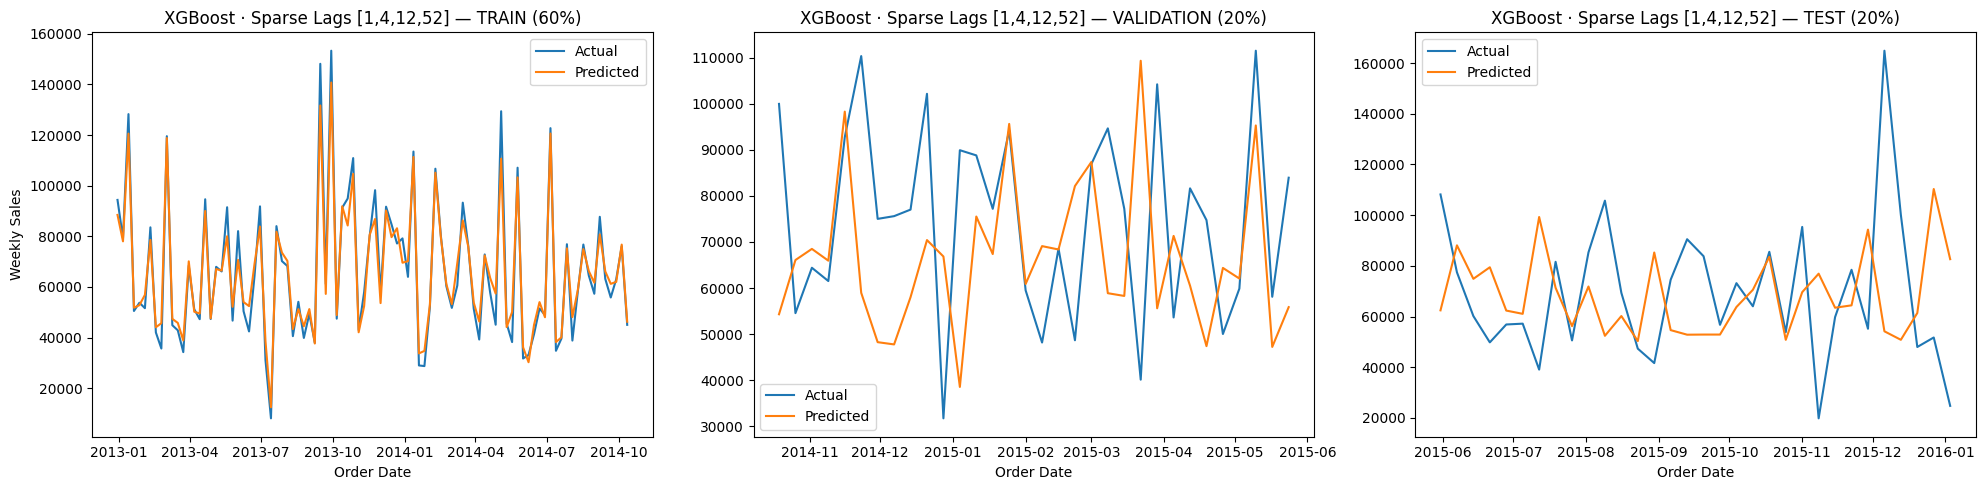

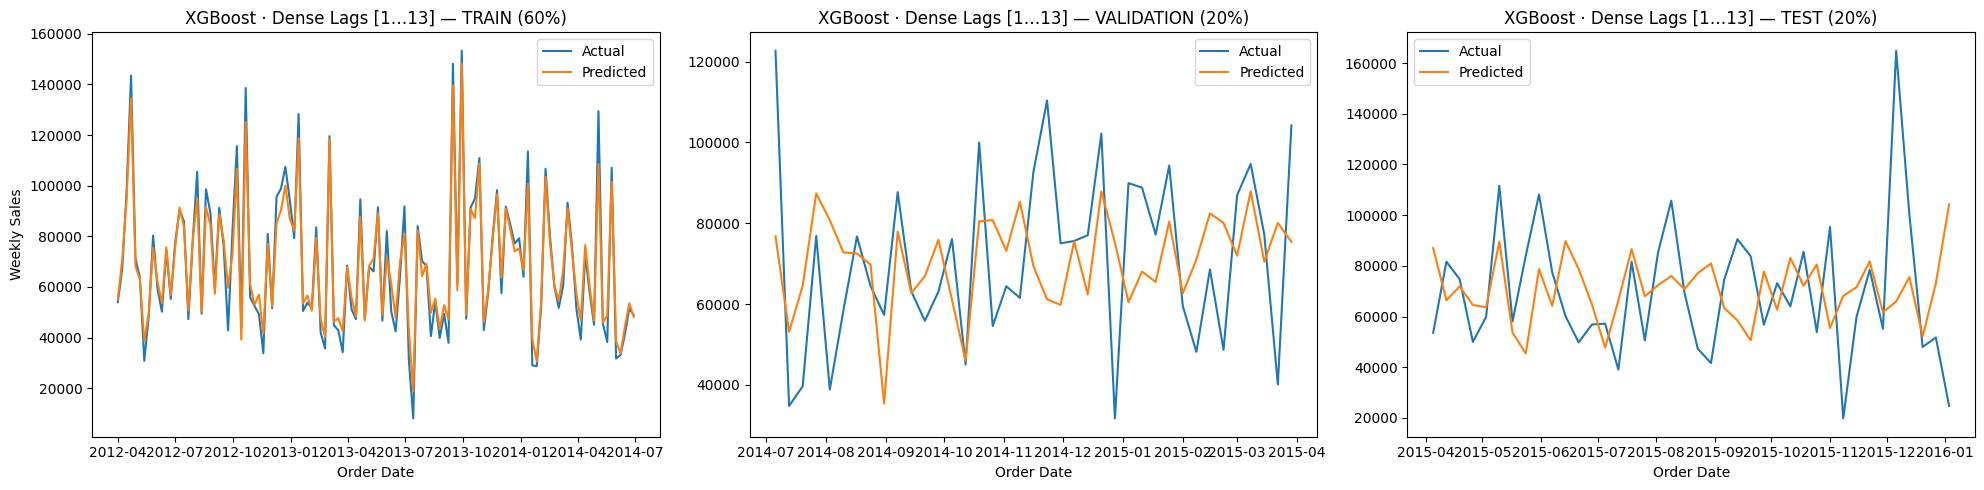

In [ ]:
# ML Model - XG Boost - 60:20:20- Dense & Sparse

import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# ======================================================
# COMMON CONFIG
# ======================================================
xgb_params = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.05,
    "subsample": 1.0,
    "colsample_bytree": 1.0,
    "objective": "reg:squarederror",
    "random_state": 42
}

# ======================================================
# FUNCTION: 60:20:20 SPLIT + PLOTS
# ======================================================
def xgb_60_20_20_plots(weekly_sales, lags, title_prefix):
    df = weekly_sales.copy()

    # Create lag features
    for lag in lags:
        df[f"lag_{lag}"] = df["Sales"].shift(lag)

    df = df.dropna().reset_index(drop=True)

    feature_cols = [f"lag_{lag}" for lag in lags]
    X = df[feature_cols]
    y = df["Sales"]
    dates = df["Order Date"]

    n = len(df)
    train_end = int(n * 0.6)
    val_end = int(n * 0.8)

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

    dates_train = dates.iloc[:train_end]
    dates_val = dates.iloc[train_end:val_end]
    dates_test = dates.iloc[val_end:]

    # Train model ONLY on training data
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train, verbose=False)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # --------------------------------------------------
    # PLOTS
    # --------------------------------------------------
    plt.figure(figsize=(20, 5))

    # TRAIN
    plt.subplot(1, 3, 1)
    plt.plot(dates_train, y_train, label="Actual")
    plt.plot(dates_train, y_train_pred, label="Predicted")
    plt.title(f"{title_prefix} — TRAIN (60%)")
    plt.xlabel("Order Date")
    plt.ylabel("Weekly Sales")
    plt.legend()

    # VALIDATION
    plt.subplot(1, 3, 2)
    plt.plot(dates_val, y_val, label="Actual")
    plt.plot(dates_val, y_val_pred, label="Predicted")
    plt.title(f"{title_prefix} — VALIDATION (20%)")
    plt.xlabel("Order Date")
    plt.legend()

    # TEST
    plt.subplot(1, 3, 3)
    plt.plot(dates_test, y_test, label="Actual")
    plt.plot(dates_test, y_test_pred, label="Predicted")
    plt.title(f"{title_prefix} — TEST (20%)")
    plt.xlabel("Order Date")
    plt.legend()

    plt.tight_layout()
    plt.show()


# ======================================================
# RUN FOR BOTH LAG CONFIGURATIONS
# ======================================================

# Sparse lags
xgb_60_20_20_plots(
    weekly_sales,
    lags=[1, 4, 12, 52],
    title_prefix="XGBoost · Sparse Lags [1,4,12,52]"
)

# Dense lags
xgb_60_20_20_plots(
    weekly_sales,
    lags=list(range(1, 14)),
    title_prefix="XGBoost · Dense Lags [1…13]"
)
